# PLAN

- [X] Acquisition
    - [X] Select what list of repos to scrape.       
        - We have selected a compounded group of repositories from the trending repositories list on github in addition to algorithmically scraped repositories that process through the search pages on Github for those that have been 'starred' the most (i.e. we are selecting generally popular repositories)
        
    - [X] Get requests from the site.
        - This is done utilizing BeautifulSoup and detailed by step in a function called get_all_readme_files_and_languages as found in an acquire.py script
        
    - [X] Save responses to csv.
        - URL extensions are saved to local csv, a list of dictionaries that give us the title, readme, and primary coding language for each repository are saved into a local .json file.  Subsequent queries after initial read from these local files to avoid hitting Github excessively with requests, which wound up being problematic after too many hits.
        
- [X] Preparation
    - [X] Prepare the data for analysis.
        - We will clean our readme data by removing special characters, numbers, and foreign languages and making the text uniform for comparison.  We will examine lemmatized and stemmed words.  We will remove common stopwords as well as the explicit languages so we are not handing ourselves the answer from what the readme might be literally saying, or subsequentally misinterpreting what the readme is saying if it references a language that they did not personally utilize.  For each repository the "Primary Language" is selected so that we are more able to apply a classification model to our dataset.  Scraped from the HTML in our acquire file, the first language class found is used in the script, as they are ordered on Github by percentage used.  If the first instance is listed as a Jupyter Notebook, the second instance is taken due to this being a file format and not a language in the pure sense.
       
       - To simplify classification, we will examine the top languages utilized by number of repositories.
       
- [ ] Exploration
    - [ ] Answer the following prompts:
        - [ ] What are the most common words in READMEs?
        - [ ] What does the distribution of IDFs (inverse document frequencies) look like for the most common words?
        - [ ] Does the length of the README vary by language?
        - [ ] Do different languages use a different number of unique words?
        
- [ ] Modeling
    - [ ] Transform the data for machine learning; use language to predict.
    - [ ] Fit several models using different text repressentations.
    - [ ] Build a function that will take in the text of a README file, and makes a prediction of language.
    
- [ ] Delivery
    - [ ] Github repo
        - [x] This notebook.
        - [ ] Documentation within the notebook.
        - [ ] README file in the repo.
        - [ ] Python scripts if applicable.
        
    - [ ] Google Slides
        - [ ] 1-2 slides only summarizing analysis.
        - [ ] Visualizations are labeled.
        - [ ] Geared for the general audience.
        - [ ] Share link @ readme file and/or classroom.

# ENVIRONMENT

In [1]:
# import acquire script: 
from acquire import get_all_readme_files_and_languages
# import prepare scripts: 
from prepare import prepare_repo_html_data
from prepare import basic_clean
# utility imports and pandas for data analysis:
import re
import unicodedata
import numpy as np
import pandas as pd
# import nltk for language analysis: 
import nltk
#matplotlib and seaborn for plotting: 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# scipy.stats for analysis
from scipy.stats import ttest_ind as ttest
from wordcloud import WordCloud
import math
# sentiment analysis importation
from afinn import Afinn

# ACQUIRE

### Collect the languages and readme files listed for each repo

In [2]:
# initialize our lists of potential excluded and extended stopwords
extra_words = []
exclude_words = []

In [3]:
# gather our repositories through our acquire function:
repositories = get_all_readme_files_and_languages()

# PREPARE

In [4]:
# create a transformed dataset dictionary, as well as a dataframe for exploration
transformed_data, df = prepare_repo_html_data(repositories, extra_words, exclude_words)

In [5]:
# check key values in transformed dataset
transformed_data[0].keys()

dict_keys(['title', 'language', 'original', 'lemmatized', 'stemmed'])

In [6]:
# check head of dataframe
df.head(3)

language                                         lemmatized  \
0      C++  welcome repository contains source code window...   
1     HTML  python 10python python c c python python java ...   
2     Ruby  css chat truly monstrous async web chat using ...   

                                            original  \
0  Welcome! This repository contains the source c...   
1  Python - 100天从新手到大师\n\n作者：骆昊\n\nPython应用领域和就业形...   
2  CSS-Only Chat\nA truly monstrous async web cha...   

                                             stemmed  \
0  welcome repository contains source code window...   
1  python 10python python c c python python java ...   
2  css chat truly monstrous async web chat using ...   

                       title  
0         microsoft/Terminal  
1  jackfrued/Python-100-Days  
2      kkuchta/css-only-chat

### Create a list of languages that are "cleaned" (lower case with no symbols) so that we can remove them from the readme texts:

In [7]:
# iterate through our dataframe to acquire unique languages, and apply transformation to them
for i in range(df.shape[0]):
    next_lang = transformed_data[i]['language'].lower()
    next_lang = re.sub(r'[^\w\s]', ' ', next_lang).strip()
    if next_lang not in extra_words:
        extra_words.append(next_lang)
# Remove languages from the readme files with another call to prepare_repo_html:
transformed_data, df = prepare_repo_html_data(repositories, extra_words, exclude_words)

In [8]:
# we will add http, https, com to our extra words to trim needless url information outside of domain,
# we will additionally remove references to github or js (common abbreviation for javascript)
# plus common variable names n and x.  Don't mean anything in the objective sense so we will disregard.
extra_words = extra_words + ['http', 'js', 'https', 'github', 'com', 'x', 'n']
extra_words

['c',
 'html',
 'ruby',
 'vue',
 'java',
 'dart',
 'python',
 'css',
 'rust',
 'shell',
 'javascript',
 'go',
 'typescript',
 'scala',
 'kotlin',
 'smarty',
 'emacs lisp',
 'lua',
 'objective c',
 'tex',
 'common lisp',
 'clojure',
 'jupyter notebook',
 'r',
 'powershell',
 'perl',
 'php',
 'http',
 'js',
 'https',
 'github',
 'com',
 'x',
 'n']

In [9]:
transformed_data, df = prepare_repo_html_data(repositories, extra_words, exclude_words)

### Note that all of the words that reference languages have been removed from the "stemmed" and "lemmatized" versions:

In [10]:
flag = False
for word in df.stemmed[1].split(' ') or word in df.lemmatized[1].split(' '):
    if word in extra_words and word != 'c':
        print(word)
        print()
        flag = True
if flag:
    print('Need to clean more...')
else:
    print('All clean!')

All clean!


# MATT -- we should drop the readmes that are in foreign languages, right? I think they would skew our analysis. But I'm not sure why this isn't working. I originally was putting it in the prepare.py file, but when I couldn't get it to work, I came to this Jupyter Notebook.

In [11]:
.5 * len(df.original[9])

772.0

In [12]:
len(df.stemmed[9])

314

In [13]:
print(len(df.stemmed[9]))
print(len(df.original[9]))
# This should select all the readmes whose stemmed versions are less than 50% as long 
# as the original versions... but it doesn't...
if len(df.stemmed) < .5 * len(df.original):
    print(df.original[:400])

314
1544


In [14]:
# reversed the sign just confirm it then prints all of the readmes... 
if len(df.stemmed) > .5 * len(df.original):
    print(df.original[:400])

0      Welcome! This repository contains the source c...
1      Python - 100天从新手到大师\n\n作者：骆昊\n\nPython应用领域和就业形...
2      CSS-Only Chat\nA truly monstrous async web cha...
3      Overview\nPowerToys is a set of utilities for ...
4      Beautifully simple click-to-copy CSS effects\n...
5      There is an English version of README here. ju...
6      Welcome to the code repository for Flutter for...
7      The Algorithms - Python \n\nAll algorithms imp...
8      📝 Make slides with Markdown easily.\n\n\n\n\n\...
9      离线阅读版本下载\n\n\n\n\n\n 算法 \n操作系统\n 网络 \n面向对象\n  ...
10     Linux Command\n \n550 多个 Linux 命令，内容包含 Linux 命...
11     Flutter is Google's mobile app SDK for craftin...
12     996.ICU\nPlease note that there exists NO othe...
13     PySOT\nPySOT is a software system designed by ...
14     🐝 Formation \n\n\nFormation is a shell script ...
15     LeetCode\n简体中文 | English\n\n\n介绍\nleetcode 题解，...
16     项目介绍\n\n项目地址：https://github.com/qianguyihao/We...
17     SQLFlow\n   \nWhat is SQ

In [15]:
# Verify we still have over 100 readmes.
df.shape

(183, 5)

In [16]:
# peek at new dataframe:
df.head() # dataframe

language                                         lemmatized  \
0      C++  welcome repository contains source code window...   
1     HTML  10devops matlab lisp 2018make english working ...   
2     Ruby  chat truly monstrous async web chat using what...   
3     Ruby  overview powertoys set utilities power users t...   
4      Vue  beautifully simple click copy effects cssfx de...   

                                            original  \
0  Welcome! This repository contains the source c...   
1  Python - 100天从新手到大师\n\n作者：骆昊\n\nPython应用领域和就业形...   
2  CSS-Only Chat\nA truly monstrous async web cha...   
3  Overview\nPowerToys is a set of utilities for ...   
4  Beautifully simple click-to-copy CSS effects\n...   

                                             stemmed  \
0  welcome repository contains source code window...   
1  10devops matlab lisp 2018make english working ...   
2  chat truly monstrous async web chat using what...   
3  overview powertoys set utilities power users t...   
4  beautifully simple click copy effects cssfx de...   

                       title  
0         microsoft/Terminal  
1  jackfrued/Python-100-Days  
2      kkuchta/css-only-chat  
3        microsoft/PowerToys  
4             jolaleye/cssfx

### And a clean list of dictionaries:

In [17]:
transformed_data[0] 

{'title': 'microsoft/Terminal',
 'language': 'C++',
 'original': 'Welcome! This repository contains the source code for:\n\nWindows Terminal\nThe Windows console host (conhost.exe)\nComponents shared between the two projects\nColorTool\nSample projects that show how to consume the Windows Console APIs\n\nBuild Status\n\n\n\nProject\nBuild Status\n\n\n\n\nTerminal\n\n\n\nColorTool\n\n\n\n\nTerminal & Console Overview\nPlease take a few minutes to review the overview below before diving into the code:\nWindows Terminal\nWindows Terminal is a new, modern, feature-rich, productive terminal application for command-line users. It includes many of the features most frequently requested by the Windows command-line community including support for tabs, rich text, globalization, configurability, theming & styling, and more.\nThe Terminal will also need to meet our goals and measures to ensure it remains fast, and efficient, and doesn\'t consume vast amounts of memory or power.\nThe Windows conso

# EXPLORE

### We will examine the utilization of words in the readme file of these common repositories.  We will examine the frequency of term use through bi-grams and tri-grams, and compare the usage of single words between languages.

In [18]:
# Get the percent of each language that is in the data set.
languages = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'percent']
languages

n   percent
JavaScript        50  0.273224
Python            23  0.125683
Java              18  0.098361
C++               14  0.076503
Go                11  0.060109
Scala              7  0.038251
HTML               7  0.038251
Objective-C        6  0.032787
Ruby               6  0.032787
TypeScript         5  0.027322
Kotlin             4  0.021858
Rust               4  0.021858
PHP                3  0.016393
Dart               3  0.016393
Shell              2  0.010929
CSS                2  0.010929
C#                 2  0.010929
C                  2  0.010929
Jupyter Notebook   2  0.010929
Smarty             2  0.010929
Vue                2  0.010929
Common Lisp        1  0.005464
Perl               1  0.005464
Emacs Lisp         1  0.005464
Lua                1  0.005464
TeX                1  0.005464
Clojure            1  0.005464
PowerShell         1  0.005464
R                  1  0.005464

In [19]:
df.stemmed[:5] # peek at the stemmed data series

0    welcome repository contains source code window...
1    10devops matlab lisp 2018make english working ...
2    chat truly monstrous async web chat using what...
3    overview powertoys set utilities power users t...
4    beautifully simple click copy effects cssfx de...
Name: stemmed, dtype: object

In [20]:
list_of_words_per_doc = []
list_of_words_per_doc

[]

In [21]:
# Get the word count and frequency for all of the readmes:
all_words = ' '.join(df.stemmed)
word_freq_for_all = pd.Series(all_words.split()).value_counts()

In [91]:
# Create a list of word frequencies per language: 
list_of_words_per_doc = [{
        'language': 'all',
        'lang_word_list': word_freq_for_all.head(20)
        }]
for repo_num in range(1, len(transformed_data)):
    word_freq_per_language ={
        'language': transformed_data[repo_num]['language'],
        'lang_word_list': pd.Series(transformed_data[repo_num]['stemmed'].split()).value_counts().head(20)
        }
    
    # have to append a copy or I'm only appending the spot that this variable points to 
    # and only end up with the last dictionary in the list.
    list_of_words_per_doc.append(word_freq_per_language)
list_of_words_per_doc

[{'language': 'all', 'lang_word_list': use          1074
  data          905
  const         813
  library       764
  array         706
  function      677
  using         635
  code          541
  object        497
  value         489
  simple        484
  top           477
  component     465
  learning      455
  server        434
  examples      422
  based         404
  return        400
  b             391
  source        383
  dtype: int64}, {'language': 'HTML', 'lang_word_list': api           8
  linux         7
  django        6
  websocket     4
  py            4
  restful       4
  selenium      4
  manage        3
  app           3
  json          3
  debug         2
  cookie        2
  nginxuwsgi    2
  redis         2
  ip            2
  mysql         2
  ftp           2
  csv           2
  gunicorn      2
  tcp           2
  dtype: int64}, {'language': 'Ruby', 'lang_word_list': button        11
  image          9
  use            9
  data           9
  page           8


### We will take a look at the most common languages by value count in our dataframe and classify from there

In [23]:
df.language.value_counts()

JavaScript          50
Python              23
Java                18
C++                 14
Go                  11
Scala                7
HTML                 7
Objective-C          6
Ruby                 6
TypeScript           5
Kotlin               4
Rust                 4
PHP                  3
Dart                 3
Shell                2
CSS                  2
C#                   2
C                    2
Jupyter Notebook     2
Smarty               2
Vue                  2
Common Lisp          1
Perl                 1
Emacs Lisp           1
Lua                  1
TeX                  1
Clojure              1
PowerShell           1
R                    1
Name: language, dtype: int64

## We will take a look at the words of the top 8 languages listed by value counts, excluding HTML (everything with 6 or more instances)

In [24]:
# Create a list of the first nine languages by value count.
top_languages = list(df.language.value_counts()[0:9].index)
top_languages

['JavaScript',
 'Python',
 'Java',
 'C++',
 'Go',
 'Scala',
 'HTML',
 'Objective-C',
 'Ruby']

In [25]:
# Remove HTML.
top_languages.remove('HTML')

In [26]:
# Peek at our top language list.
top_languages

['JavaScript', 'Python', 'Java', 'C++', 'Go', 'Scala', 'Objective-C', 'Ruby']

In [27]:
# Reduce dataframe to top 8 languages.
df = df[df.language.isin(top_languages)]

In [28]:
# See how many samples we are left with:
df.shape

(135, 5)

In [29]:
# Ensure that the trimming worked:
df.language.value_counts()

JavaScript     50
Python         23
Java           18
C++            14
Go             11
Scala           7
Objective-C     6
Ruby            6
Name: language, dtype: int64

## We have 135 samples and 8 different languages for classification! A great start.  Let's get our hands dirty.

In [30]:
# obtain word count and frequency for entire data set:
all_words = ' '.join(df.stemmed)
word_freq_for_all = pd.Series(all_words.split()).value_counts()

In [31]:
# make words based on joined strings where dataframe criteria meets stated conditions:
javascript_words = ' '.join(df[df.language == 'JavaScript'].stemmed)
cplusplus_words = ' '.join(df[df.language == 'C++'].stemmed)
python_words = ' '.join(df[df.language == 'Python'].stemmed)
java_words = ' '.join(df[df.language == 'Java'].stemmed)
go_words = ' '.join(df[df.language == 'Go'].stemmed)
ruby_words = ' '.join(df[df.language == 'Ruby'].stemmed)
scala_words = ' '.join(df[df.language == 'Scala'].stemmed)
obj_c_words = ' '.join(df[df.language == 'Objective-C'].stemmed)

In [32]:
# calculate word frequencies for each large string of language-use words
javascript_freq = pd.Series(javascript_words.split()).value_counts()
cplusplus_freq = pd.Series(cplusplus_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
go_freq = pd.Series(go_words.split()).value_counts()
ruby_freq = pd.Series(ruby_words.split()).value_counts()
scala_freq = pd.Series(scala_words.split()).value_counts()
obj_c_freq = pd.Series(obj_c_words.split()).value_counts()

In [33]:
# get word counts together and concatinate them into a single dataframe:

word_counts = (pd.concat([word_freq_for_all, javascript_freq, cplusplus_freq, python_freq, java_freq, go_freq, ruby_freq, scala_freq, obj_c_freq], axis=1, sort=True)
                .set_axis(['all', 'javascript', 'cplusplus', 'python', 'java', 'go', 'ruby', 'scala', 'obj_c'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

#peek at top head of word counts and tail of word counts
word_counts.head().append(word_counts.tail())

all  javascript  cplusplus  python  java  go  ruby  \
0                      3           0          1       1     0   1     0   
0000000view            1           1          0       0     0   0     0   
00000todo              1           0          0       0     1   0     0   
0000ns                 2           0          0       2     0   0     0   
0001001001therefore    1           0          0       1     0   0     0   
zxcvbn                 1           1          0       0     0   0     0   
zxf                    1           0          0       1     0   0     0   
zynga                  1           0          0       1     0   0     0   
zyszys                 1           1          0       0     0   0     0   
zyszys9gmail           1           1          0       0     0   0     0   

                     scala  obj_c  
0                        0      0  
0000000view              0      0  
00000todo                0      0  
0000ns                   0      0  
0001001001therefore      0      0  
zxcvbn                   0      0  
zxf                      0      0  
zynga                    0      0  
zyszys                   0      0  
zyszys9gmail             0      0

## Let's investigate the most common words across our data set:

In [34]:
# most common words (stemmed) across data set
word_counts.sort_values(by='all', ascending=False).head(10)

all  javascript  cplusplus  python  java   go  ruby  scala  obj_c
use       1074         745         22     175    25   53    17     18     19
data       905         341         20     421    14   88    11      9      1
const      813         810          3       0     0    0     0      0      0
library    764          95         26     323     6  270     5     31      8
array      706         690          0      10     0    3     0      2      1
function   677         626         16      20     7    6     0      2      0
using      635         378         26     125    12   74     8      6      6
code       541         224         44     133    21   88    11     11      9
object     497         393         37      53     1    7     0      1      5
value      489         333         33      76     8   29     0      0     10

### JavaScript, Python, Java, and C++ are the most common languages, so let's look at them.

In [35]:
pd.concat([word_counts.sort_values(by='javascript').tail(3),
           word_counts.sort_values(by='python').tail(3),
           word_counts.sort_values(by='java').tail(3),
          word_counts.sort_values(by='cplusplus').tail(3)])

all  javascript  cplusplus  python  java   go  ruby  scala  obj_c
array      706         690          0      10     0    3     0      2      1
use       1074         745         22     175    25   53    17     18     19
const      813         810          3       0     0    0     0      0      0
library    764          95         26     323     6  270     5     31      8
learning   455          27         16     388     0   22     0      2      0
data       905         341         20     421    14   88    11      9      1
flowable    34           0          0       0    34    0     0      0      0
type       257          99         13      46    37   14     2     32     14
license    188          65         13      16    41   16    10     23      4
cache      222          76         58      72     1   13     0      2      0
swift       98           3         72      12     0    0     0      0     11
build      372         200         73      24     9   47     3      8      8

In [36]:
# Look at only Javascript and Python
# Look at the word counts in one language when the other does not have any occurences 
# of that word.
jvs_pyt = pd.DataFrame() 
jvs_pyt = pd.concat([word_counts[word_counts.python == 0].sort_values(by='javascript').tail(),
           word_counts[word_counts.javascript == 0].sort_values(by='python').tail()])
jvs_pyt[['all', 'javascript', 'python']]

all  javascript  python
obj        198         198       0
val        299         269       0
arr        303         303       0
prototype  356         351       0
const      813         810       0
julia       47           0      45
science     55           0      46
2b          57           0      56
natural     75           0      64
httpie      99           0      99

In [37]:
# compare difference between javascript and python top words
pd.concat([word_counts[['javascript', 'python']][word_counts.javascript == 0].sort_values(by='python').tail(6),
           word_counts[['javascript', 'python']][word_counts.python == 0].sort_values(by='javascript').tail(6)])

javascript  python
cs                  0      39
julia               0      45
science             0      46
2b                  0      56
natural             0      64
httpie              0      99
vuex              182       0
obj               198       0
val               269       0
arr               303       0
prototype         351       0
const             810       0

### Let's compare Javascript and Java.

In [38]:
jvs_java = pd.DataFrame() 
jvs_java = pd.concat([word_counts[word_counts.java == 0].sort_values(by='javascript').tail(),
           word_counts[word_counts.javascript == 0].sort_values(by='java').tail()])
jvs_java[['all', 'javascript', 'java']]

all  javascript  java
arr         303         303     0
prototype   356         351     0
component   465         457     0
array       706         690     0
const       813         810     0
println      16           0    16
schedulers   22           0    21
reactivex    21           0    21
rxjava       29           0    28
flowable     34           0    34

### And now Javascript and C++...

In [39]:
jvs_cpp = pd.DataFrame() 
jvs_cpp = pd.concat([word_counts[word_counts.cplusplus == 0].sort_values(by='javascript').tail(),
           word_counts[word_counts.javascript == 0].sort_values(by='cplusplus').tail()])
jvs_cpp[['all', 'javascript', 'cplusplus']]

all  javascript  cplusplus
val        299         269          0
arr        303         303          0
b          391         367          0
component  465         457          0
array      706         690          0
science     55           0          7
catboost    17           0         13
gpu         36           0         14
cmake       16           0         15
xcode       30           0         20

### And Python and Java...

In [40]:
pyt_java = pd.DataFrame() 
pyt_java = pd.concat([word_counts[word_counts.java == 0].sort_values(by='python').tail(),
           word_counts[word_counts.python == 0].sort_values(by='java').tail()])
pyt_java[['all', 'python', 'java']]

all  python  java
neural      125     102     0
django      115     104     0
framework   304     111     0
machine     337     288     0
learning    455     388     0
println      16       0    16
reactivex    21       0    21
schedulers   22       0    21
rxjava       29       0    28
flowable     34       0    34

### Python and C++

In [41]:
pyt_cpp = pd.DataFrame() 
pyt_cpp = pd.concat([word_counts[word_counts.cplusplus == 0].sort_values(by='python').tail(),
           word_counts[word_counts.python == 0].sort_values(by='cplusplus').tail()])
pyt_cpp[['all', 'python', 'cplusplus']]

all  python  cplusplus
planet         58      56          0
2b             57      56          0
output        103      73          0
httpie         99      99          0
deprecated    166     158          0
generatefunc   20       0         10
toolchain      12       0         11
nightly        18       0         14
xcode          30       0         20
ninja          26       0         23

### Java and C++

In [42]:
java_cpp = pd.DataFrame() 
java_cpp = pd.concat([word_counts[word_counts.cplusplus == 0].sort_values(by='java').tail(),
           word_counts[word_counts.java == 0].sort_values(by='cplusplus').tail()])
java_cpp[['all', 'java', 'cplusplus']]

all  java  cplusplus
elasticsearch   47    20          0
reactivex       21    21          0
schedulers      22    21          0
v              186    21          0
flowable        34    34          0
key            297     0         25
framework      304     0         32
tensorflow      72     0         33
electron        85     0         48
swift           98     0         72

### Let's create a bar graph to visualize the proportion of language for each of the 20 most common words.

Text(0.5, 1.0, 'Proportion of language for the 20 most common words')

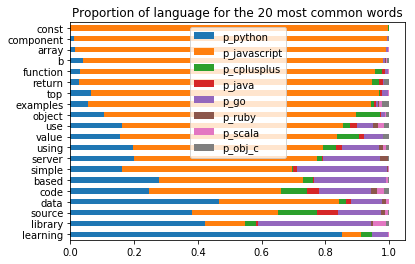

In [43]:
(word_counts
 .assign(p_python = word_counts.python / word_counts['all'],
         p_javascript = word_counts.javascript / word_counts['all'], 
         p_cplusplus = word_counts.cplusplus / word_counts['all'],
         p_java = word_counts.java / word_counts['all'], 
         p_go = word_counts.go / word_counts['all'], 
         p_ruby = word_counts.ruby / word_counts['all'], 
         p_scala = word_counts.scala / word_counts['all'],
         p_obj_c = word_counts.obj_c / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_javascript', 'p_cplusplus', 'p_java', 'p_go', 'p_ruby', 'p_scala', 'p_obj_c']]
 .tail(20)
 .sort_values('p_javascript')
 .plot.barh(stacked=True))

plt.title('Proportion of language for the 20 most common words')

# So the most common words will likely be good predictors of the language. "const" is a very strong predictor of Javascript and "learning" is an almost as strong predictor of Python.

# Let's visualize the words common for each language in word clouds.

### First, all words:

(-0.5, 799.5, 399.5, -0.5)

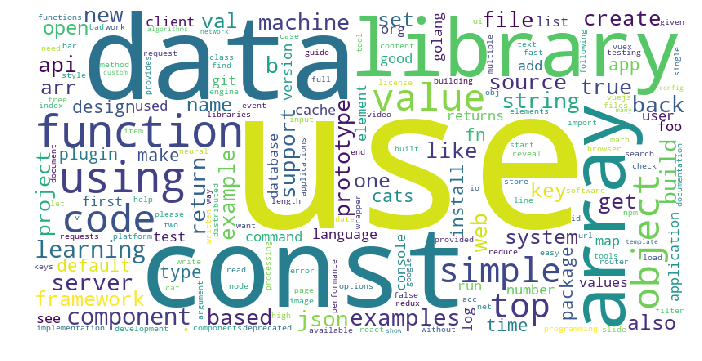

In [44]:
cloud = WordCloud(background_color='white', width=800, height=400)
all_img = cloud.generate_from_frequencies(word_freq_for_all)
plt.figure(figsize=(20, 6))
plt.imshow(all_img)
plt.axis('off')

# Print the most common words per language and
# Create wordclouds for each language

Top words in All Readme Files
use         1074
data         905
const        813
library      764
array        706
function     677
using        635
code         541
object       497
value        489
dtype: int64
Top words in Javascript
const        810
use          745
array        690
function     626
component    457
top          431
object       393
using        378
examples     375
return       368
dtype: int64
Top words in Python
data          421
learning      388
library       323
machine       288
use           175
deprecated    158
system        153
source        146
design        135
code          133
dtype: int64
Top words in C++
build         73
swift         72
cache         58
electron      48
source        46
code          44
object        37
windows       36
open          34
tensorflow    33
dtype: int64
Top words in Java
license     41
type        37
flowable    34
single      29
io          28
rxjava      28
system      27
index       26
use         25
source      25

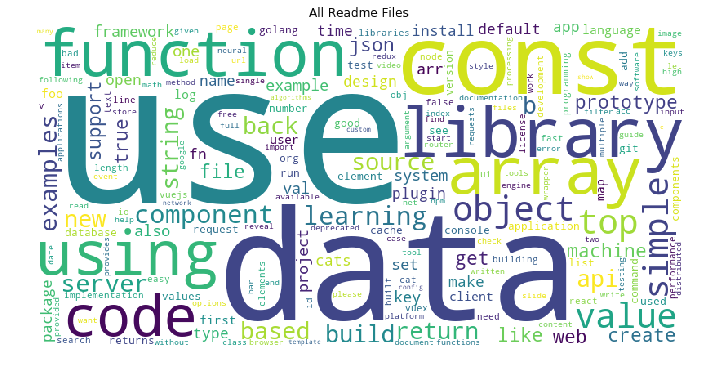

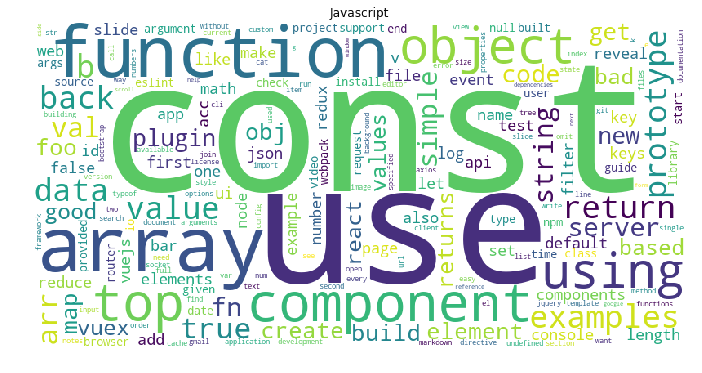

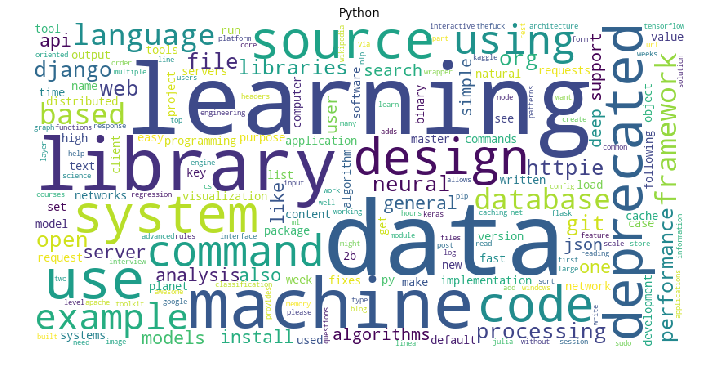

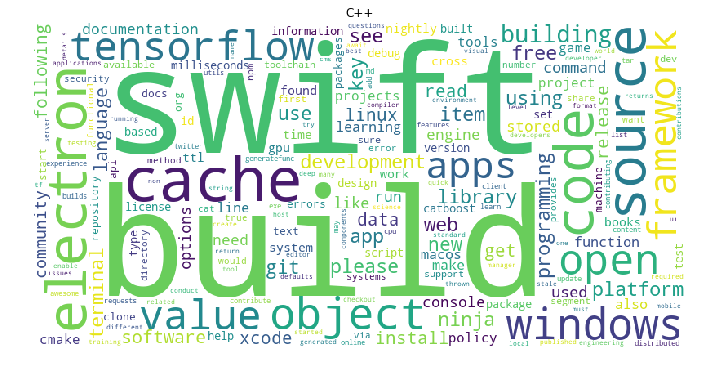

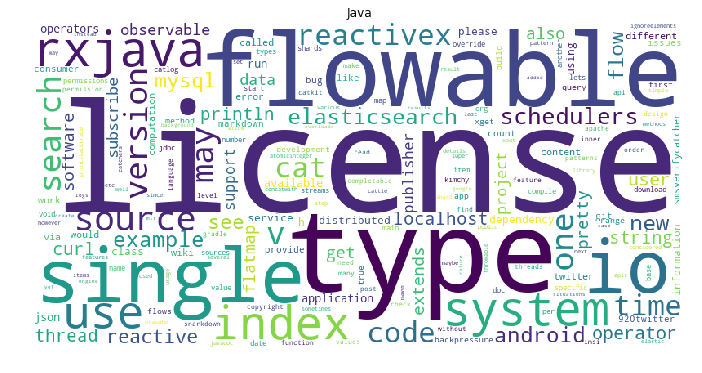

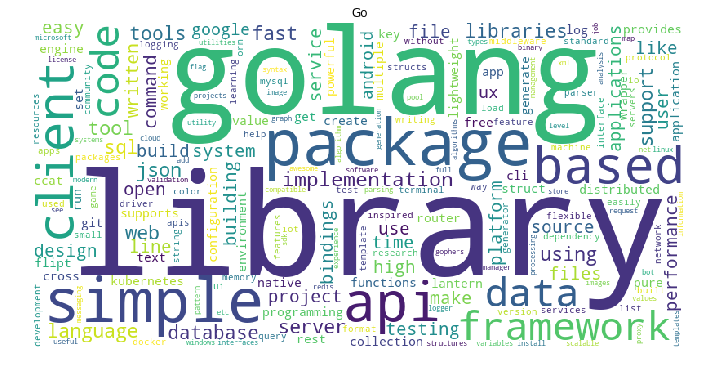

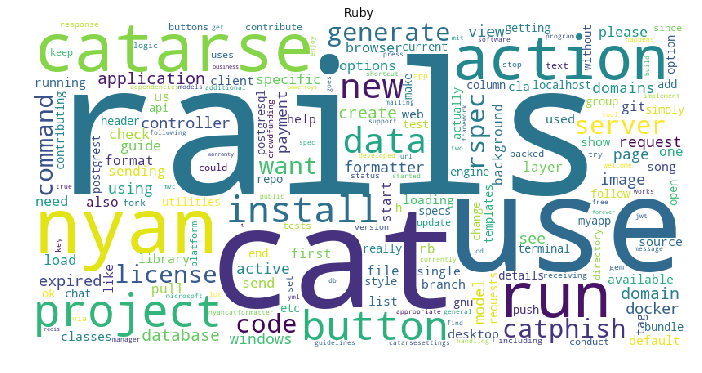

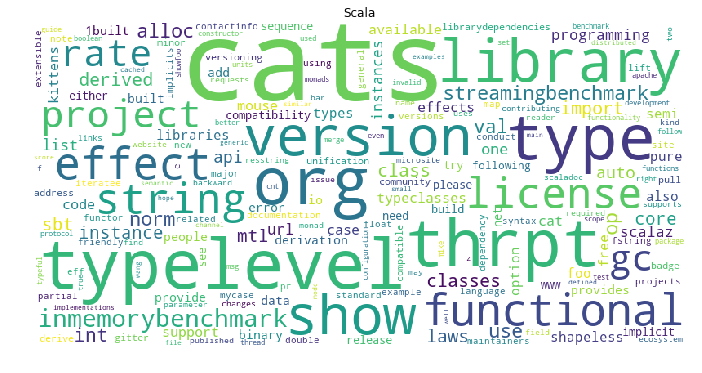

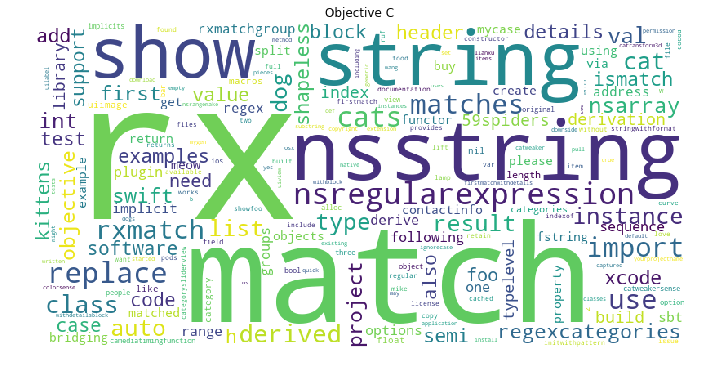

In [45]:
#create a list of our word frequencies and create a word cloud for each iteratively
freq_list = [word_freq_for_all, javascript_freq, python_freq, cplusplus_freq, java_freq, go_freq, ruby_freq, scala_freq, obj_c_freq]
langs = ['All Readme Files', 'Javascript', 'Python', 'C++', 'Java', 'Go', 'Ruby', 'Scala', 'Objective C']
for n, item in enumerate(freq_list): 
    print('Top words in ' + langs[n])
    print(item[0:10])
    cloud = WordCloud(background_color='white', width=800, height=400)
    all_img = cloud.generate_from_frequencies(item)
    plt.figure(figsize=(20, 6))
    plt.imshow(all_img)
    plt.title(langs[n])
    plt.axis('off')

What does the distribution of IDFs (inverse document frequencies) look like for the most common words?

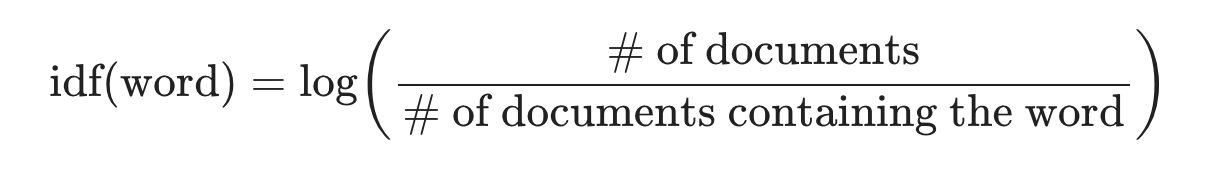

# Calculate IDF for each document

In [95]:
idf = pd.Series()
top_20_words_from_all = list_of_words_per_doc[0]['lang_word_list'].index
for num, word in enumerate(top_20_words_from_all): 
    num_docs_with_word = 0
    
    # check each word list for this word
    for repo_word_list in list_of_words_per_doc[1:]:
        if word in repo_word_list['lang_word_list']:
            num_docs_with_word += 1
    numerator = len(list_of_words_per_doc)-1
    denominator = num_docs_with_word
    fraction = numerator/denominator
    idf[word] = (word, [math.log10(fraction)])
idf

use                (use, [0.5788301506094876])
data              (data, [0.8287076238260874])
const             (const, [1.561101383649056])
library          (library, [1.18089014193745])
array            (array, [1.7829501332654123])
function      (function, [1.3569814009931311])
using            (using, [0.8287076238260874])
code              (code, [0.6266029324054883])
object           (object, [1.481920137601431])
value             (value, [1.414973347970818])
simple          (simple, [1.2600713879850747])
top                (top, [1.9590413923210936])
component    (component, [1.6580113966571124])
learning       (learning, [1.414973347970818])
server          (server, [1.0296224666068008])
examples      (examples, [1.9590413923210936])
based             (based, [1.561101383649056])
return          (return, [1.9590413923210936])
b                    (b, [1.7829501332654123])
source          (source, [0.9590413923210935])
dtype: object

# Let's create a dataframe containing the ten most common words per language with their word counts.

In [53]:
word_freq_for_all.values[:10]

array([1074,  905,  813,  764,  706,  677,  635,  541,  497,  489])

In [54]:
combined_freq_df = pd.DataFrame()
combined_freq_df['all_w'] = word_freq_for_all.index[:10]
combined_freq_df['all_v'] = word_freq_for_all.values[:10]

combined_freq_df['js_w'] = javascript_freq .index[:10]
combined_freq_df['js_v'] = javascript_freq .values[:10]

combined_freq_df['cpp_w'] = cplusplus_freq.index[:10]
combined_freq_df['cpp_v'] = cplusplus_freq.values[:10]

combined_freq_df['python_w'] = python_freq.index[:10]
combined_freq_df['python_v'] = python_freq.values[:10]

combined_freq_df['java_w'] = java_freq.index[:10]
combined_freq_df['java_v'] = java_freq.values[:10]

combined_freq_df['go_w'] = go_freq.index[:10]
combined_freq_df['go_v'] = go_freq.values[:10]

combined_freq_df['ruby_w'] = ruby_freq.index[:10]
combined_freq_df['ruby_v'] = ruby_freq.values[:10]

combined_freq_df['scala_w'] = scala_freq.index[:10]
combined_freq_df['scala_v'] = scala_freq.values[:10]

combined_freq_df['obj_c_w'] = obj_c_freq.index[:10]
combined_freq_df['obj_c_v'] = obj_c_freq.values[:10]

combined_freq_df

all_w  all_v       js_w  js_v       cpp_w  cpp_v    python_w  python_v  \
0       use   1074      const   810       build     73        data       421   
1      data    905        use   745       swift     72    learning       388   
2     const    813      array   690       cache     58     library       323   
3   library    764   function   626    electron     48     machine       288   
4     array    706  component   457      source     46         use       175   
5  function    677        top   431        code     44  deprecated       158   
6     using    635     object   393      object     37      system       153   
7      code    541      using   378     windows     36      source       146   
8    object    497   examples   375        open     34      design       135   
9     value    489     return   368  tensorflow     33        code       133   

     java_w  java_v       go_w  go_v   ruby_w  ruby_v     scala_w  scala_v  \
0   license      41    library   270    rails      37        cats      178   
1      type      37     golang   198      cat      19   typelevel       40   
2  flowable      34    package   139      use      17         org       36   
3    single      29     simple   137     nyan      17       thrpt       36   
4        io      28        api   109  catarse      17        type       32   
5    rxjava      28     client    92      run      15     library       31   
6    system      27      based    91   action      14     version       27   
7     index      26  framework    88  project      13        show       27   
8       use      25       data    88   button      13  functional       26   
9    source      25       code    88  install      12      effect       26   

               obj_c_w  obj_c_v  
0                   rx       82  
1                match       41  
2             nsstring       39  
3               string       33  
4                 show       28  
5  nsregularexpression       24  
6              replace       21  
7                 cats       20  
8              matches       19  
9               import       19

## Consider the sentiment score for each language.

In [55]:
# create afinn instance
afinn = Afinn()

# MATT-- I have no idea why this didn't work. That's why I ran the commands and then manually created the series. But the results are significant.

In [56]:
df.columns

Index(['language', 'lemmatized', 'original', 'stemmed', 'title'], dtype='object')

In [57]:
df['orig_sentiment'] = df.original.apply(afinn.score)
df['lem_sentiment'] = df.lemmatized.apply(afinn.score)
df['stem_sentiment'] = df.stemmed.apply(afinn.score)
df

language                                         lemmatized  \
0           C++  welcome repository contains source code window...   
2          Ruby  chat truly monstrous async web chat using what...   
3          Ruby  overview powertoys set utilities power users t...   
5          Java  english version readme click leetcode 11222k 2...   
7        Python  algorithms algorithms implemented education im...   
9          Java  offer leetcode linux socket sql leetcode datab...   
15   JavaScript  leetcode english leetcode leetcode leetcode an...   
16   JavaScript  qianguyihao web web androidweb 2019web issues ...   
17           Go  sqlflow sqlflow sqlflow bridge connects sql en...   
18           Go  perfbook document outlines best practices writ...   
19         Java  special sponsors programmer advancement snailc...   
21           Go  feature flag solution runs existing infrastruc...   
22           Go  awesome product design collection bookmarks re...   
23         Java  cat cat cat cat node mvc rpc cat cat 484483cat...   
24          C++  latest version single header downloaded direct...   
25       Python  nyaavsetting development project uses features...   
26           Go  ccat ccat colorizing cat works similar cat dis...   
27       Python  deep learning cats repository toy project gain...   
29          C++  cataclysm dark days ahead cataclysm dark days ...   
30        Scala  community announcements apr 2201launched susta...   
31          C++  website documentation installation release not...   
32         Ruby  repo deprecated please send pull requests comm...   
33   JavaScript  wscat websocket cat installation module needs ...   
34   JavaScript  cat clicker premium vanilla ben solution cat c...   
35       Python  service master develop ci badge catalyst algor...   
37         Java  catkit android kit cat placeholders usage dens...   
38         Java  android catloadingview project idea link thank...   
39         Java  android imsi catcher detector project revival ...   
41          C++  cat 11functional library cat cat 11functional ...   
42         Ruby  nyan cat rspec formatter take nyan cat rspec f...   
..          ...                                                ...   
148      Python  open source society university path free self ...   
149  JavaScript  resume service creates resume based repos acti...   
152  JavaScript  lodash site docs fp guide contributing wiki co...   
154  JavaScript  webpack webpack module bundler main purpose bu...   
155  JavaScript  algorithms data structures repository contains...   
156  JavaScript  atom atom hackable text editor 21st century bu...   
157  JavaScript  redux predictable state container apps confuse...   
159         C++  swift programming language architecture master...   
160        Java  design patterns implemented introduction desig...   
161  JavaScript  material ui react components implement google ...   
162  JavaScript  socket io features socket io enables real time...   
164  JavaScript  reveal framework easily creating beautiful pre...   
165  JavaScript  semantic ui semantic ui framework designed the...   
166  JavaScript  awesome curated list awesome things related re...   
167  JavaScript  submit tutorial table contents 3d renderer aug...   
168  JavaScript  3seconds code curated collection useful snippe...   
169      Python  flask flask lightweight wsgi web application f...   
170  JavaScript  fast unopinionated minimalist web framework no...   
171      Python  fuck fuck magnificent app inspired liamosaur t...   
172          Go  awesome financial support awesome curated list...   
173  JavaScript  simple yet flexible charting designers develop...   
174      Python  django high level web framework encourages rap...   
175      Python  httpie cli curl like tool humans httpie pronou...   
176  JavaScript  lightweight date library parsing validating ma...   
177  JavaScript  meteor ultra simple environment building moder...   
178        Java  

In [58]:
combined_freq_df

all_w  all_v       js_w  js_v       cpp_w  cpp_v    python_w  python_v  \
0       use   1074      const   810       build     73        data       421   
1      data    905        use   745       swift     72    learning       388   
2     const    813      array   690       cache     58     library       323   
3   library    764   function   626    electron     48     machine       288   
4     array    706  component   457      source     46         use       175   
5  function    677        top   431        code     44  deprecated       158   
6     using    635     object   393      object     37      system       153   
7      code    541      using   378     windows     36      source       146   
8    object    497   examples   375        open     34      design       135   
9     value    489     return   368  tensorflow     33        code       133   

     java_w  java_v       go_w  go_v   ruby_w  ruby_v     scala_w  scala_v  \
0   license      41    library   270    rails      37        cats      178   
1      type      37     golang   198      cat      19   typelevel       40   
2  flowable      34    package   139      use      17         org       36   
3    single      29     simple   137     nyan      17       thrpt       36   
4        io      28        api   109  catarse      17        type       32   
5    rxjava      28     client    92      run      15     library       31   
6    system      27      based    91   action      14     version       27   
7     index      26  framework    88  project      13        show       27   
8       use      25       data    88   button      13  functional       26   
9    source      25       code    88  install      12      effect       26   

               obj_c_w  obj_c_v  
0                   rx       82  
1                match       41  
2             nsstring       39  
3               string       33  
4                 show       28  
5  nsregularexpression       24  
6              replace       21  
7                 cats       20  
8              matches       19  
9               import       19

In [59]:
pd.Series(all_words).apply(afinn.score)[0]

7707.0

In [60]:
sentiment_score = pd.DataFrame()
# df['orig_sentiment'] = df.original.apply(afinn.score)
# words = pd.Series(document.split())

sentiment_score['all'] = pd.Series(all_words.split()).apply(afinn.score)[0]
sentiment_score['javascript'] = pd.Series(javascript_words.split()).apply(afinn.score)[0]
sentiment_score['cpp'] = pd.Series(cplusplus_words.split()).apply(afinn.score)[0]
sentiment_score['python'] = pd.Series(python_words.split()).apply(afinn.score)[0]
sentiment_score['java'] = pd.Series(java_words.split()).apply(afinn.score)[0]
sentiment_score['go'] = pd.Series(go_words.split()).apply(afinn.score)[0]
sentiment_score['java'] = pd.Series(ruby_words.split()).apply(afinn.score)[0]
sentiment_score['scala'] = pd.Series(scala_words.split()).apply(afinn.score)[0]
sentiment_score['ob_c'] = pd.Series(obj_c_words.split()).apply(afinn.score)[0]

In [61]:
sentiment_scores = pd.Series([7857, 3935, 604, 1545, 180, 1198, 155, 168, 72],
                             ['all', 'javascript', 'cpp', 'python', 'java', 'go', 'ruby', 'scala', 'obj_c']
                             )
sentiment_scores.sort_values(ascending=False)

all           7857
javascript    3935
python        1545
go            1198
cpp            604
java           180
scala          168
ruby           155
obj_c           72
dtype: int64

In [62]:
int(afinn.score(all_words))

7707

In [63]:
int(afinn.score(javascript_words))

3850

In [64]:
int(afinn.score(cplusplus_words))

593

In [65]:
int(afinn.score(python_words))

1512

In [66]:
int(afinn.score(java_words))

176

In [67]:
int(afinn.score(go_words))

1190

In [68]:
int(afinn.score(ruby_words))

149

In [69]:
int(afinn.score(scala_words))

165

In [70]:
int(afinn.score(obj_c_words))

72

### Store each sentiment score and the name of the language in a series.

In [71]:
sentiment_scores = pd.Series([7857, 3935, 604, 1545, 180, 1198, 155, 168, 72],
                             ['all', 'javascript', 'cpp', 'python', 'java', 'go', 'ruby', 'scala', 'obj_c']
                             )
sentiment_scores.sort_values(ascending=False)

all           7857
javascript    3935
python        1545
go            1198
cpp            604
java           180
scala          168
ruby           155
obj_c           72
dtype: int64

### These scores look like they will be good predictors of the language.

# Now let's examine the length of the readme files.

In [72]:
# sanity check: ensure there are only the top 8 languages in our dataframe:
df.language.value_counts()

JavaScript     50
Python         23
Java           18
C++            14
Go             11
Scala           7
Objective-C     6
Ruby            6
Name: language, dtype: int64

### Here, we will create a series of the total count of words divided by the number of instances where that language occurs in our dataframe.  This will produce a visual list of the average number of words in each readme per language.

In [73]:
lengths = pd.Series([len(all_words.split(' '))/df.shape[0],\
                     len(javascript_words.split(' '))/df[df.language=='JavaScript'].shape[0],\
                     len(python_words.split(' '))/df[df.language=='Python'].shape[0],\
                     len(go_words.split(' '))/df[df.language=='Go'].shape[0],\
                     len(cplusplus_words.split(' '))/df[df.language=='C++'].shape[0],\
                     len(java_words.split(' '))/df[df.language=='Java'].shape[0],\
                     len(scala_words.split(' '))/df[df.language=='Scala'].shape[0],\
                     len(ruby_words.split(' '))/df[df.language=='Ruby'].shape[0],\
                     len(obj_c_words.split(' '))/df[df.language=='Objective-C'].shape[0]],\
                    ['all', 'javascript', 'python', 'go', 'cpp', 'java', 'scala', 'ruby', 'obj_c'],
    )
print('Average Word Count of Readme.md by language')
print(lengths)

Average Word Count of Readme.md by language
all           1076.303704
javascript    1429.240000
python        1611.826087
go            1578.090909
cpp            479.857143
java           266.388889
scala          525.142857
ruby           321.500000
obj_c          381.666667
dtype: float64


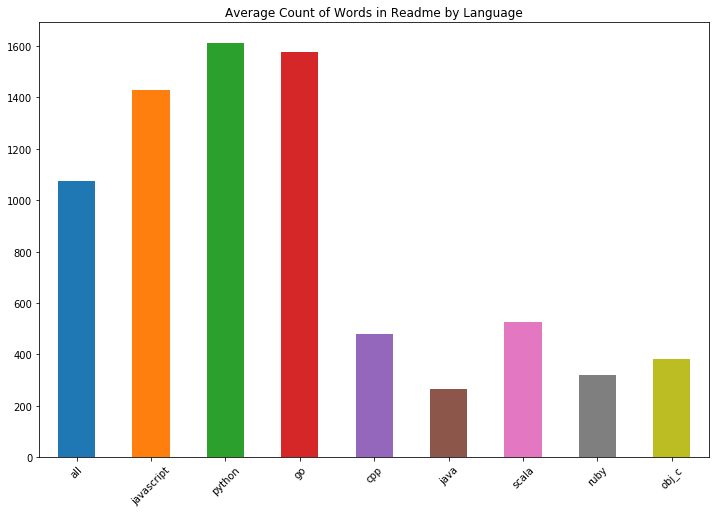

In [74]:
#plot the series of average word counts: 
lengths.plot.bar(figsize=(12,8))
plt.title('Average Count of Words in Readme by Language')
plt.xticks(rotation=45)
plt.show()

## We can note that there is an elevated number of words in Python specifically, but not to a degree of outlying compared to javascript or go.  The less popular languages also appear to have a highly reduced number of words in the readme.  It would be interesting to investigate if this is based on age or demographic of these particular coding languages and the cultures surrounding them vs the more popular ones, which are the more en-vogue coding languages of the current era.

# Now let's consider pairs of words (bigrams).

In [75]:
#create our bigrams using nltk, selecting 2 for n in ngrams, made into a series and sorted by value counts
all_bigrams = pd.Series(nltk.ngrams(all_words.strip().split(' '), 2)).value_counts()
js_bigrams = pd.Series(nltk.ngrams(javascript_words.split(' '), 2)).value_counts()
py_bigrams = pd.Series(nltk.ngrams(python_words.split(' '), 2)).value_counts()
java_bigrams = pd.Series(nltk.ngrams(java_words.split(' '), 2)).value_counts()
cplusplus_bigrams = pd.Series(nltk.ngrams(cplusplus_words.split(' '), 2)).value_counts()
go_bigrams = pd.Series(nltk.ngrams(go_words.split(' '), 2)).value_counts()
scala_bigrams = pd.Series(nltk.ngrams(scala_words.split(' '), 2)).value_counts()
ruby_bigrams = pd.Series(nltk.ngrams(ruby_words.split(' '), 2)).value_counts()
objc_bigrams = pd.Series(nltk.ngrams(obj_c_words.split(' '), 2)).value_counts()

Text(0.5, 1.0, '20 Most frequently occuring bigrams in all readme files')

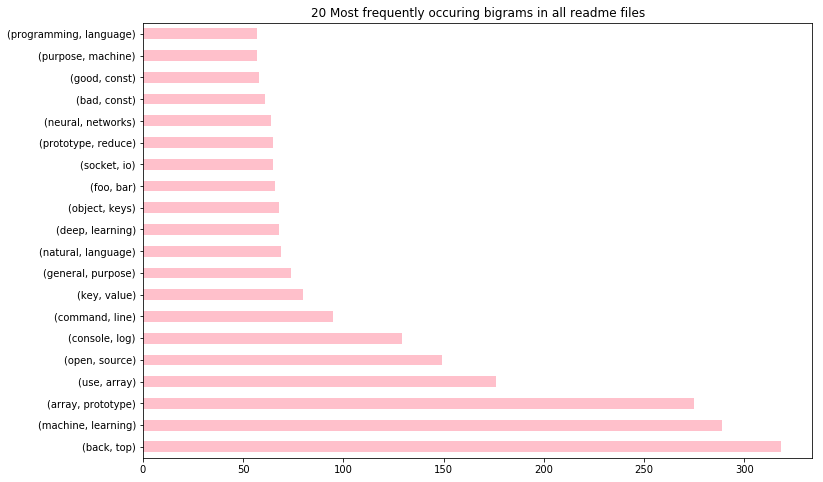

In [76]:
#plot the bigrams of all words
all_bigrams\
    .head(20)\
    .plot.barh(figsize=(12, 8), color='pink')
plt.title('20 Most frequently occuring bigrams in all readme files')

### Let's Look at the bigrams for each common programming language:

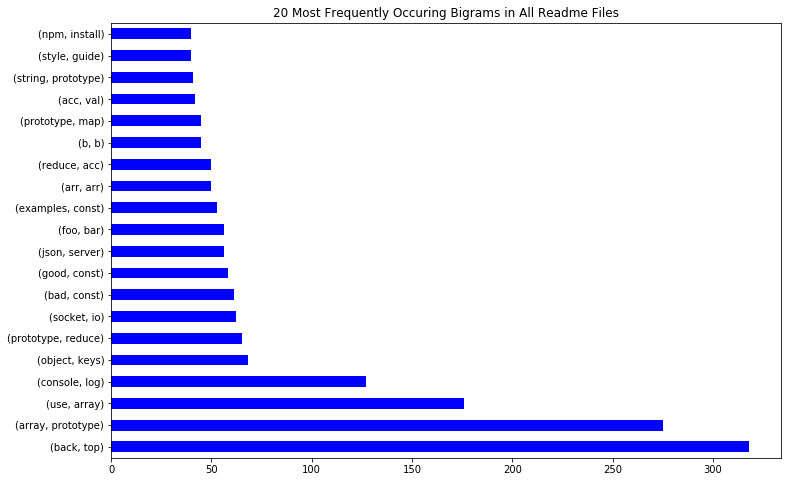

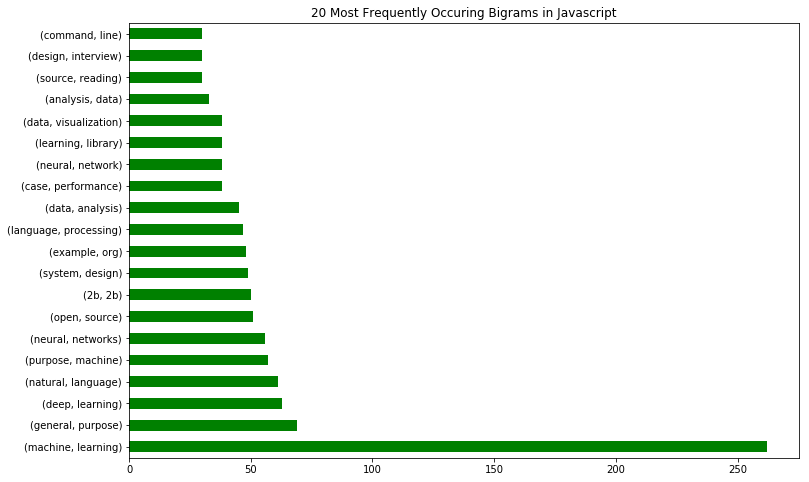

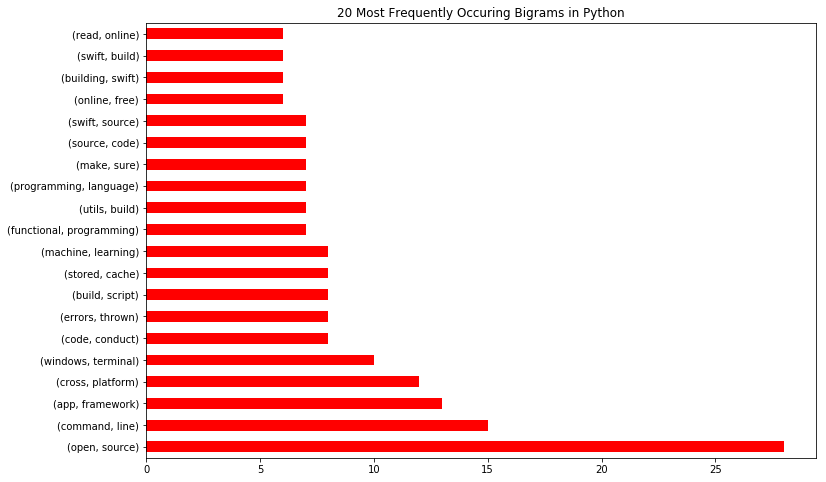

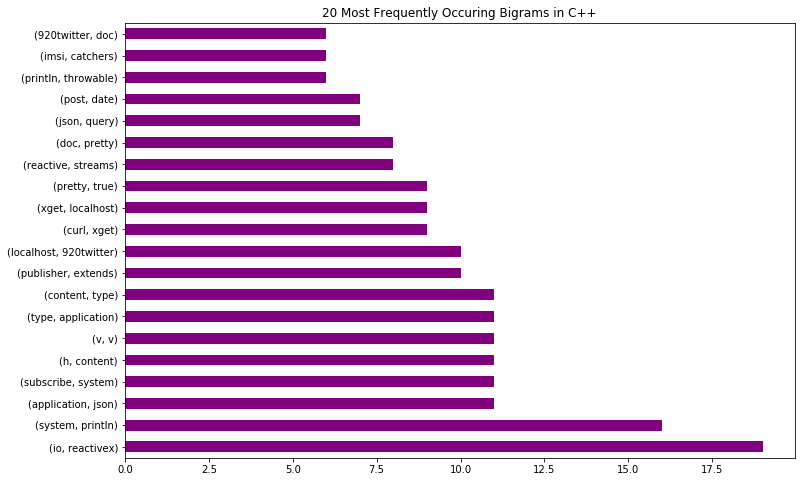

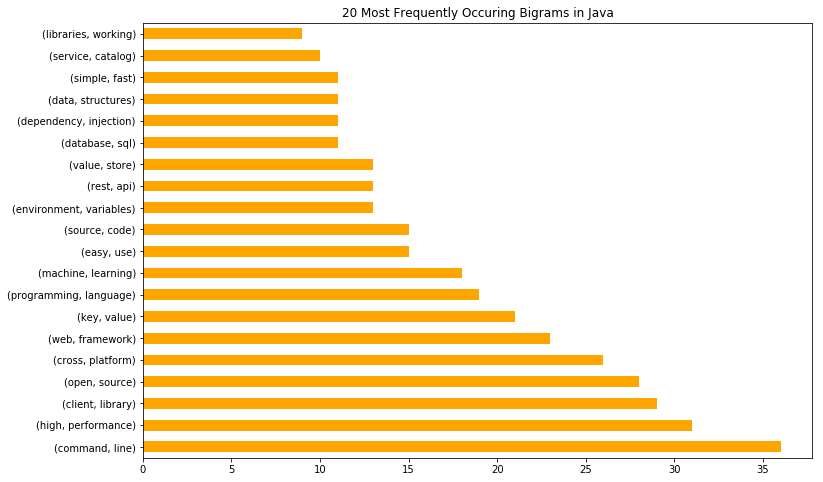

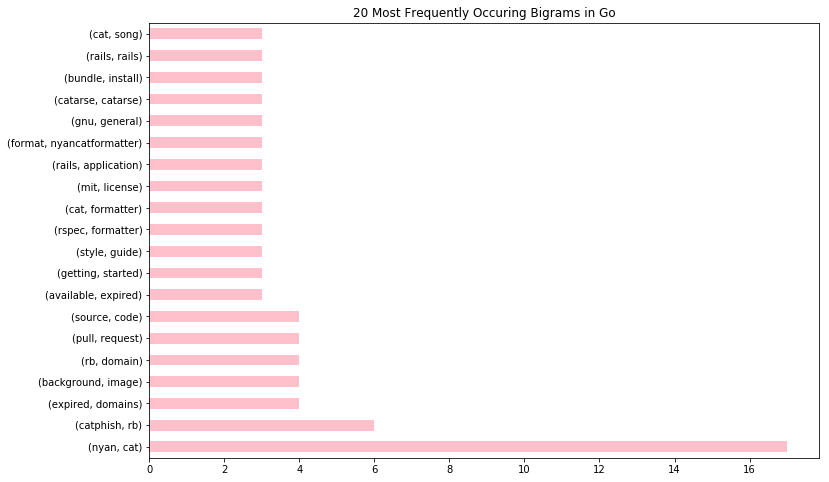

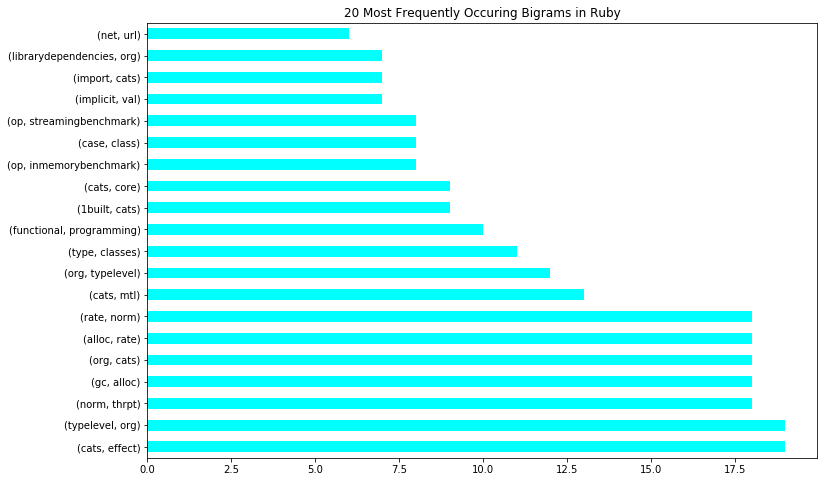

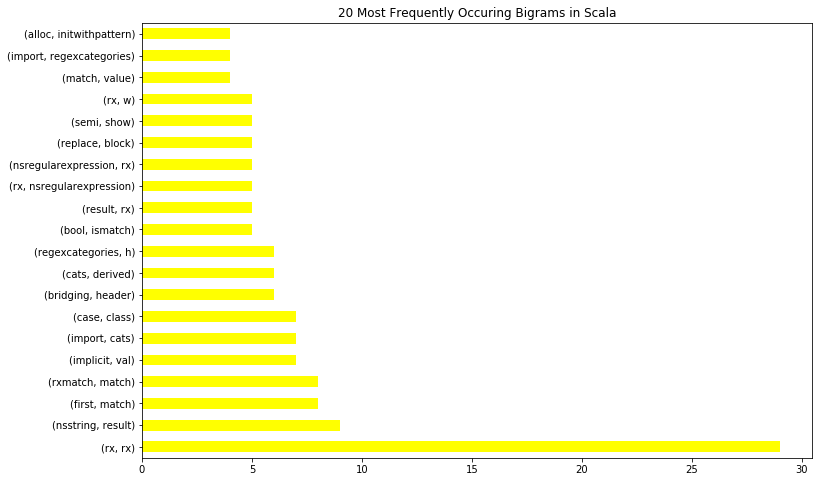

In [77]:
#bar plot the languages:
# list the bigram variable sets
bigrams = [js_bigrams, py_bigrams, cplusplus_bigrams, java_bigrams, go_bigrams, ruby_bigrams, scala_bigrams, objc_bigrams]
# list of colors for variety
colors = ['blue', 'green', 'red', 'purple', 'orange', 'pink', 'cyan', 'yellow']
for n, i in enumerate(bigrams):
    i\
    .head(20)\
    .plot.barh(figsize=(12, 8), color=colors[n])
    plt.title(f'20 Most Frequently Occuring Bigrams in {langs[n]}')
    plt.show()

In [78]:
# ~~~~~If there's anything we want to implement here we can but otherwise its redundant now:
# top_20_bigram_freq_all[1:].sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

# plt.title('20 Most frequently occuring bigrams in all readme files')
# plt.ylabel('Bigram')
# plt.xlabel('# Occurances')

# # make the labels pretty
# ticks, _ = plt.yticks()
# labels = top_20_bigram_freq_all[1:].reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
# _ = plt.yticks(ticks, labels)

### Let's look at some word-clouds of bigrams across our dataset!
## First, take a peek at the most common bigrams across the entire set of words:

(-0.5, 799.5, 399.5, -0.5)

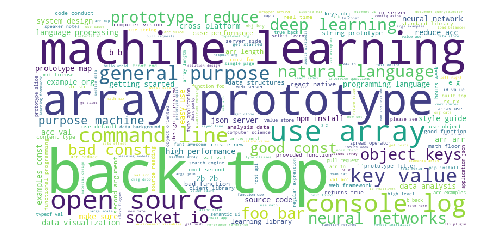

In [79]:
# map a dictionary of bigrams for use in wordcloud plotting:
frequencies = {k[0] + ' ' + k[1]: v for k, v in all_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(frequencies)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

### Let's look at the languages individually now: 

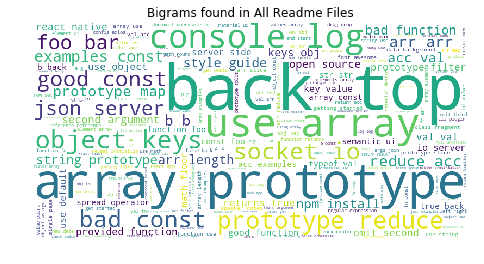

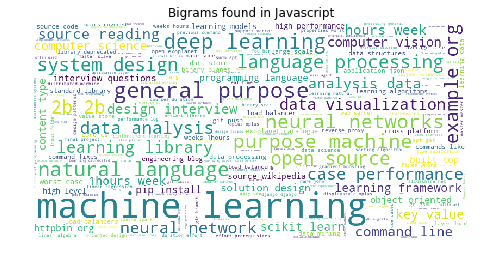

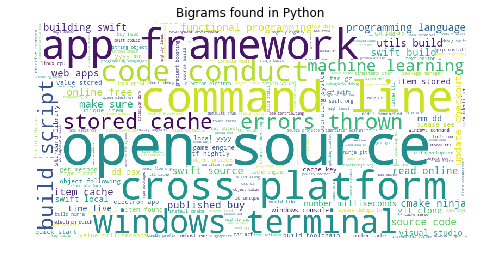

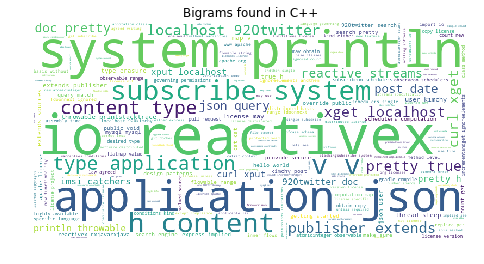

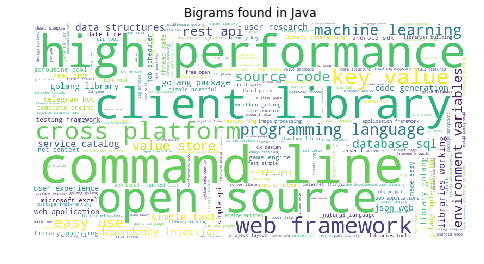

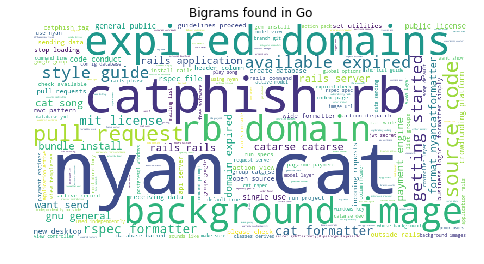

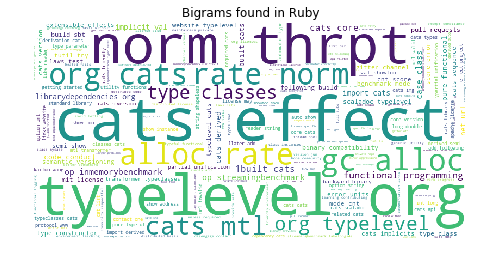

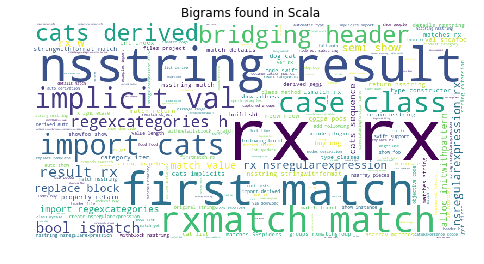

In [80]:
#loop through our languages and create independent wordclouds of each:
for n, item in enumerate(bigrams):
    frequencies = {k[0] + ' ' + k[1]: v for k, v in item\
                   .to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(frequencies)
    plt.figure(figsize=(8, 4))
    plt.imshow(img)
    plt.title(f'Bigrams found in {langs[n]}')
    plt.axis('off')

## TRIGRAMS! N=3! HUZZAH!

In [81]:
#create our trigrams using nltk, selecting 3 for n in ngrams, made into a series and sorted by value counts
all_trigrams = pd.Series(nltk.ngrams(all_words.strip().split(' '), 3)).value_counts()
js_trigrams = pd.Series(nltk.ngrams(javascript_words.split(' '), 3)).value_counts()
py_trigrams = pd.Series(nltk.ngrams(python_words.split(' '), 3)).value_counts()
java_trigrams = pd.Series(nltk.ngrams(java_words.split(' '), 3)).value_counts()
cplusplus_trigrams = pd.Series(nltk.ngrams(cplusplus_words.split(' '), 3)).value_counts()
go_trigrams = pd.Series(nltk.ngrams(go_words.split(' '), 3)).value_counts()
scala_trigrams = pd.Series(nltk.ngrams(scala_words.split(' '), 3)).value_counts()
ruby_trigrams = pd.Series(nltk.ngrams(ruby_words.split(' '), 3)).value_counts()
objc_trigrams = pd.Series(nltk.ngrams(obj_c_words.split(' '), 3)).value_counts()

Text(0.5, 1.0, '20 Most frequently occuring trigrams in all readme files')

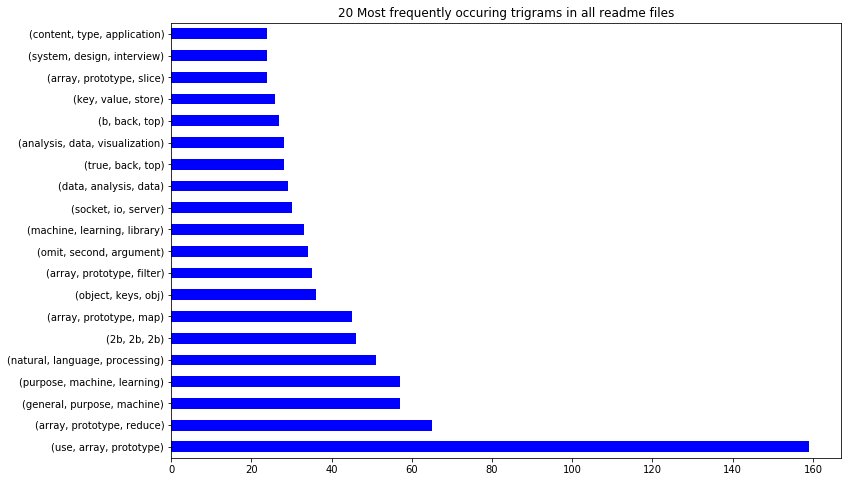

In [82]:
#plot the trigrams of all words
all_trigrams\
    .head(20)\
    .plot.barh(figsize=(12, 8), color='blue')
plt.title('20 Most frequently occuring trigrams in all readme files')

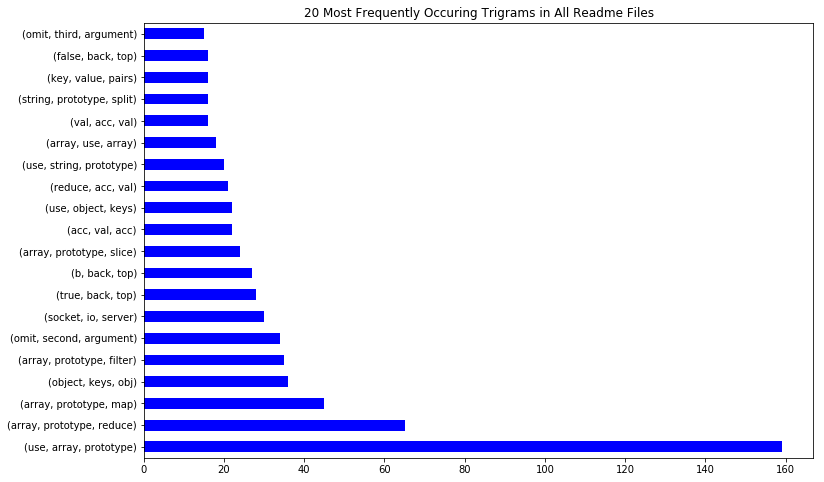

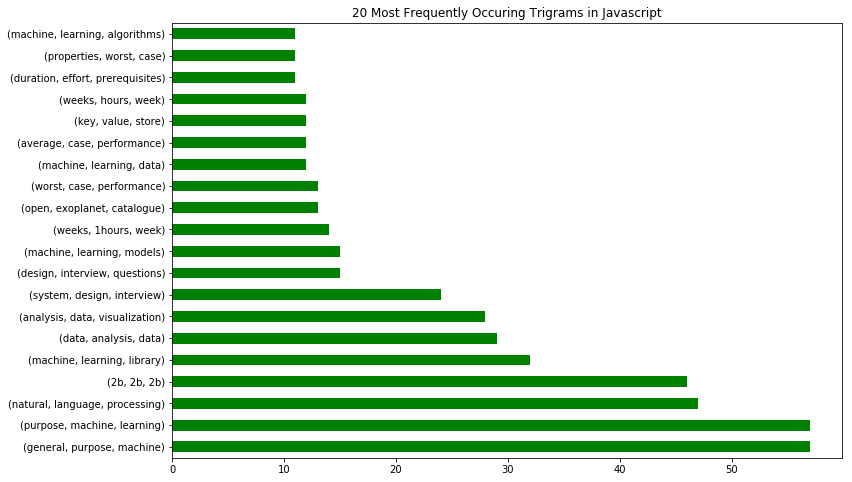

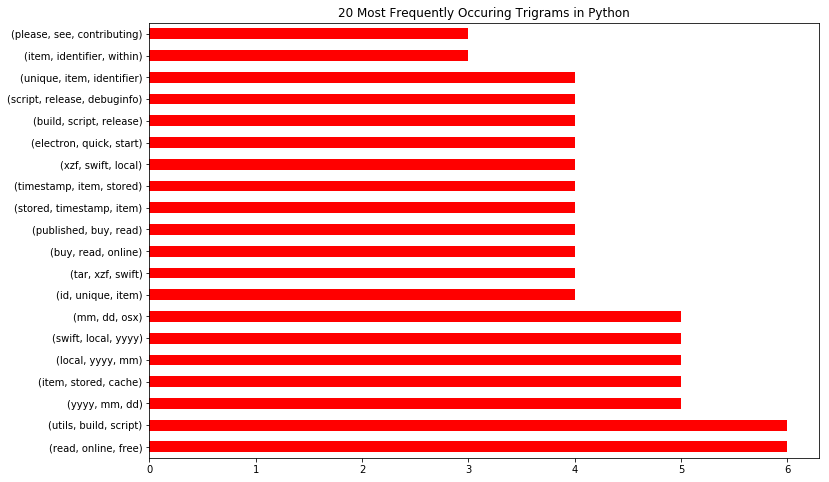

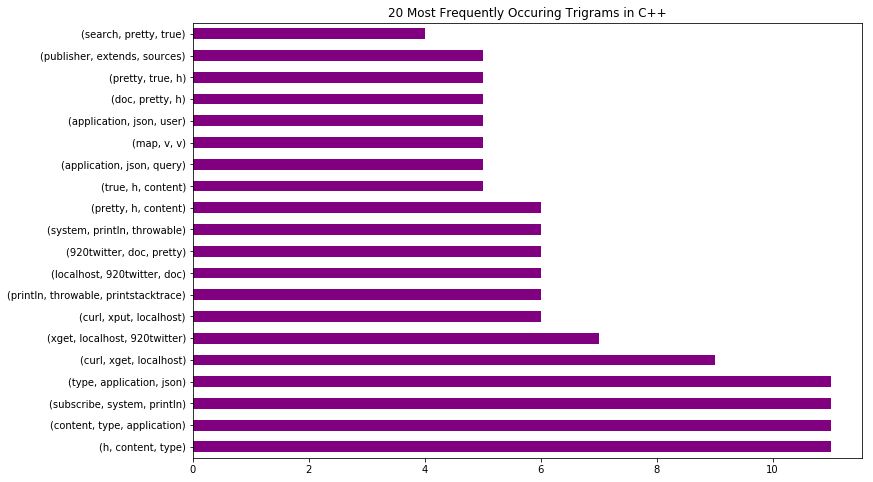

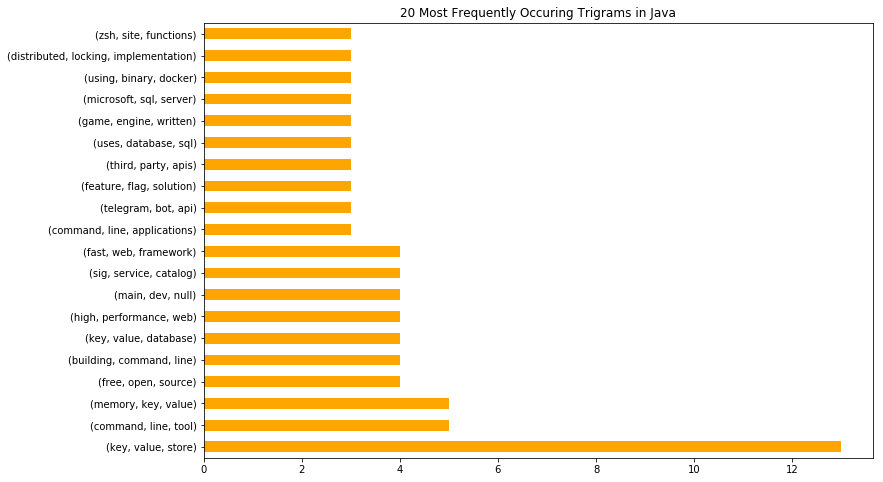

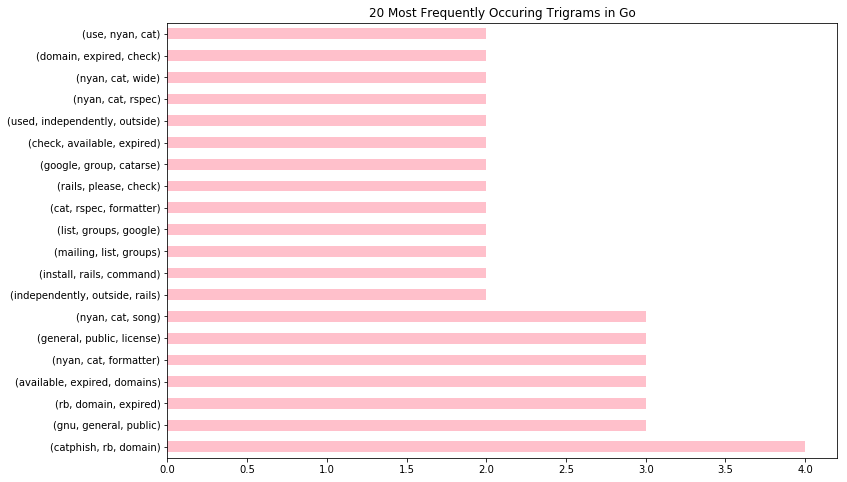

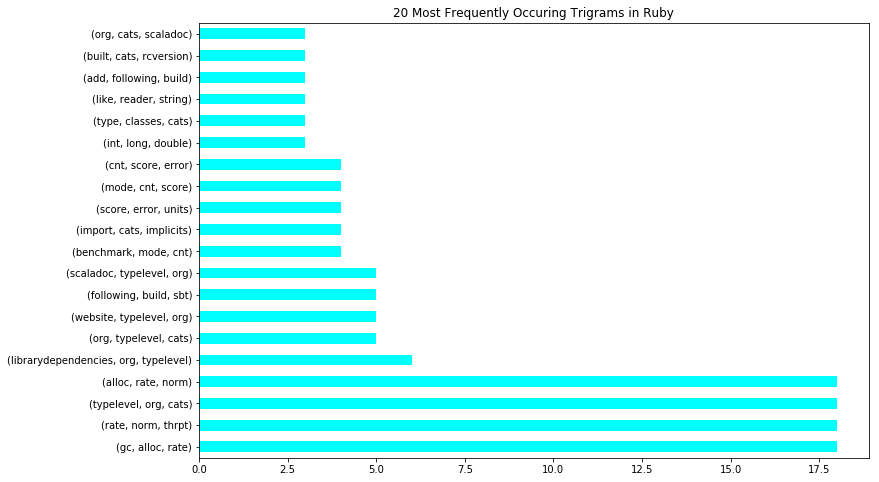

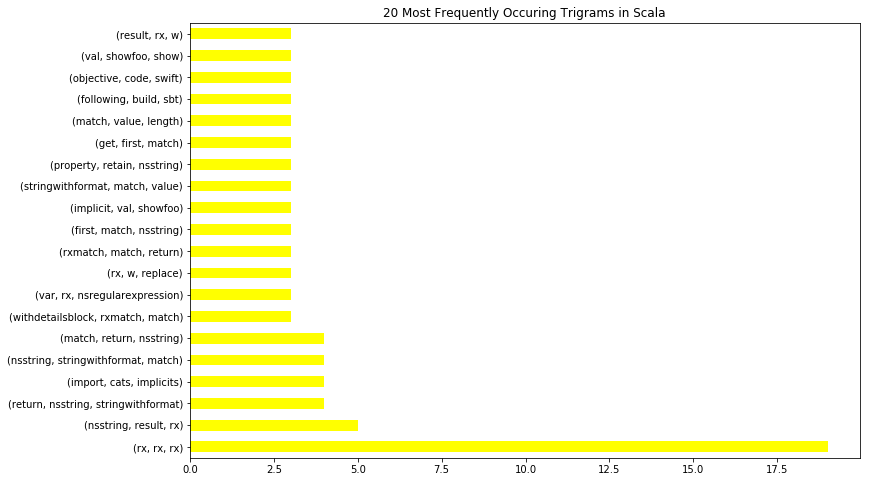

In [83]:
#bar plot the languages:
# list the trigram variable sets
trigrams = [js_trigrams, py_trigrams, cplusplus_trigrams, java_trigrams, go_trigrams, ruby_trigrams, scala_trigrams, objc_trigrams]
# list of colors for variety
colors = ['blue', 'green', 'red', 'purple', 'orange', 'pink', 'cyan', 'yellow']
for n, i in enumerate(trigrams):
    i\
    .head(20)\
    .plot.barh(figsize=(12, 8), color=colors[n])
    plt.title(f'20 Most Frequently Occuring Trigrams in {langs[n]}')
    plt.show()

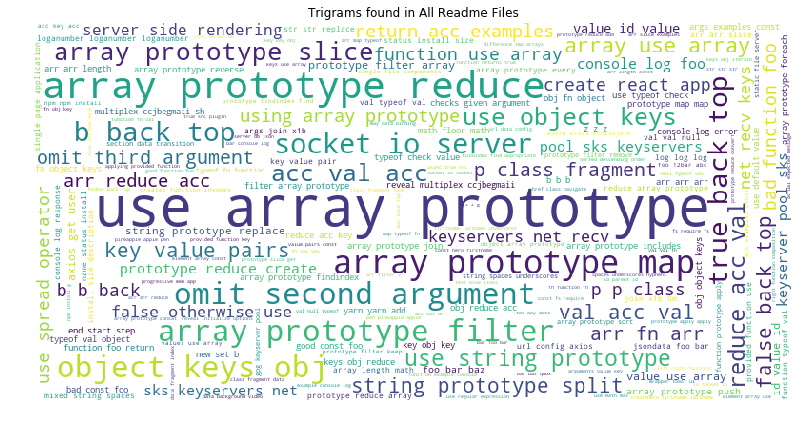

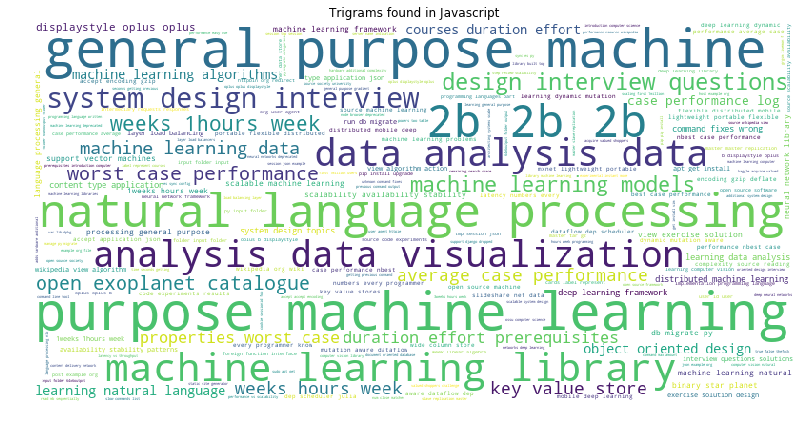

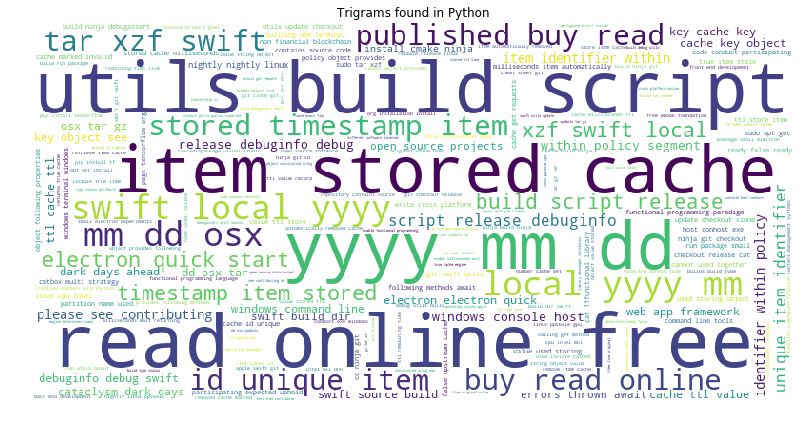

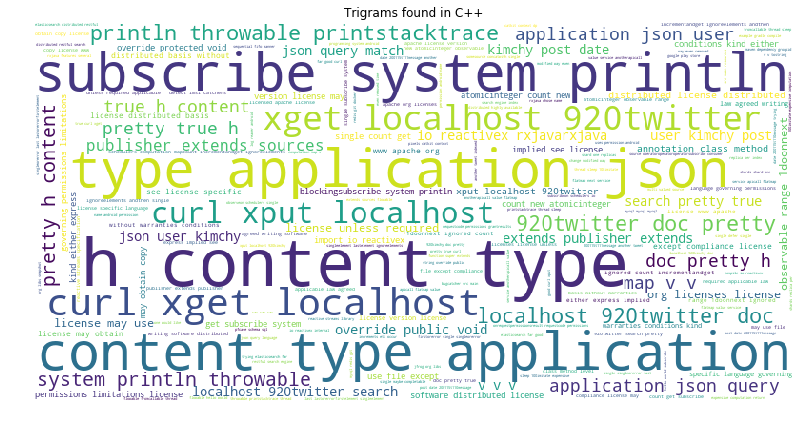

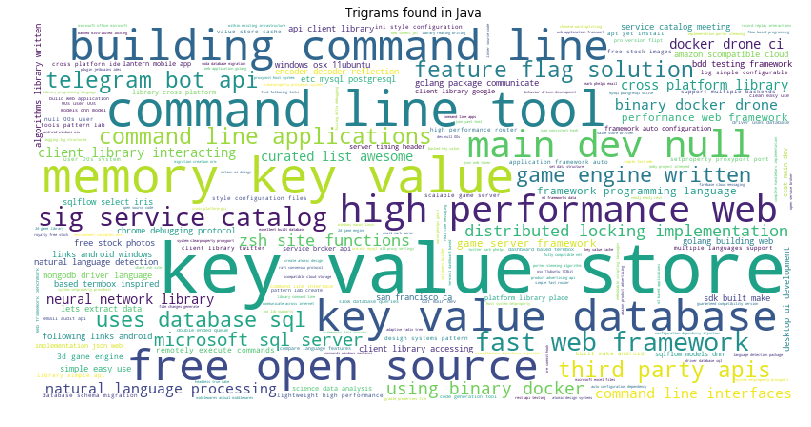

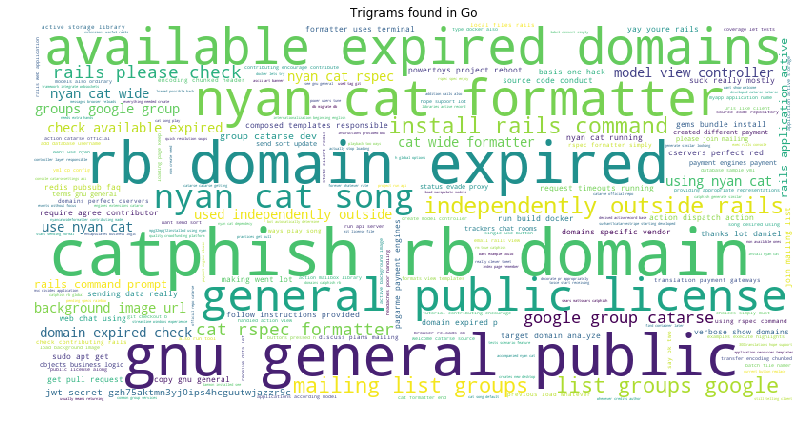

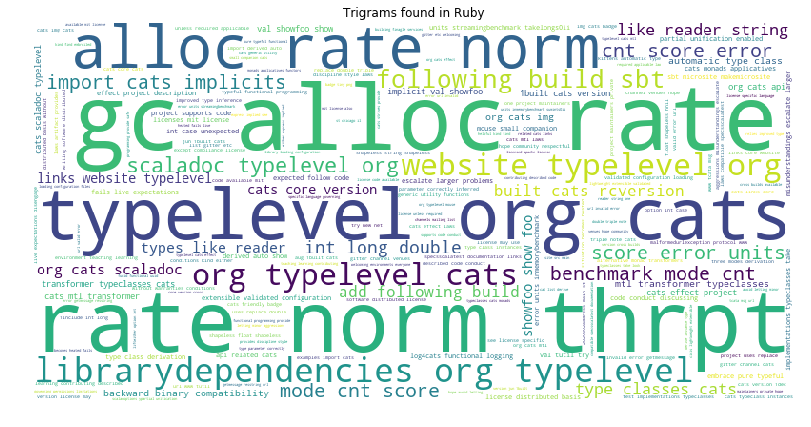

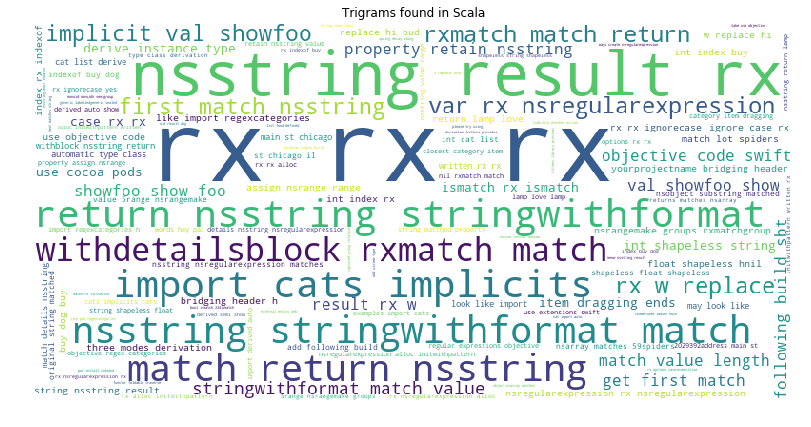

In [84]:
#loop through our languages and create independent wordclouds of each:
for n, item in enumerate(trigrams):
    frequencies = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in item\
                   .to_dict().items()}
    img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(frequencies)
    plt.figure(figsize=(15, 7))
    plt.imshow(img)
    plt.title(f'Trigrams found in {langs[n]}')
    plt.axis('off')

# If there is anything we find useful implement from below we can, otherwise its a little wonky due to the structure of the bigram series they way they were initially structured.

In [85]:
# bigram_counts = (pd.concat([top_20_bigram_freq_all, top_20_bigram_freq_js, 
#                             top_20_bigram_freq_python, top_20_bigram_freq_java, 
#                             top_20_bigram_freq_cpp, top_20_bigram_freq_go, 
#                             top_20_bigram_freq_scala, top_20_bigram_freq_ruby, 
#                             top_20_bigram_freq_obj_c], axis=1, sort=True)
#                 .set_axis(['all', 'js', 
#                            'python', 'java', 
#                            'cplusplus', 'go', 
#                            'scala', 'ruby', 
#                            'obj_c'], axis=1, inplace=False)
#                 .fillna(0)
#                 .apply(lambda s: s.astype(int)))

# bigram_counts.head().append(word_counts.tail())

In [86]:
# (bigram_counts
#  .assign(bigrams_js = top_20_bigram_freq_js / top_20_bigram_freq_all,
#          bigrams_python = top_20_bigram_freq_python / top_20_bigram_freq_all, 
#          bigrams_java = top_20_bigram_freq_java / top_20_bigram_freq_all,
#          bigrams_cpp = top_20_bigram_freq_cpp / top_20_bigram_freq_all, 
#          bigrams_go = top_20_bigram_freq_go / top_20_bigram_freq_all, 
#          bigrams_scala = top_20_bigram_freq_scala / top_20_bigram_freq_all,
#          bigrams_ruby = top_20_bigram_freq_ruby / top_20_bigram_freq_all,
#          bigrams_obj_c = top_20_bigram_freq_obj_c / top_20_bigram_freq_all)
#  .sort_values(by=top_20_bigram_freq_all)
#  [['js', 'python', 'java', 'cplusplus', 'go', 'scala', 'go', 'scala', 'ruby', 'obj_c']]
#  .tail(20)
#  .sort_values(top_20_bigram_freq_all)
#  .plot.barh(stacked=True))

# plt.title('Proportion of language for the 20 most common bigrams')

In [87]:
# bigram_freq_for_all = pd.Series(top_20_all_bigrams.split()).value_counts()
# js_bigram_freq = pd.Series(top_20_js_bigrams.split()).value_counts()
# python_bigram_freq = pd.Series(top_20_python_bigrams.split()).value_counts()
# java_bigram_freq = pd.Series(top_20_java_bigrams.split()).value_counts()
# cpp_bigram_freq = pd.Series(top_20_cpp_bigrams.split()).value_counts()

In [88]:
# bi_counts = (pd.concat([bigram_freq_for_all, jjs_bigram_freq, python_bigram_freq, java_bigram_freq, cpp_bigram_freq], axis=1, sort=True)
#                 .set_axis(['all', 'javascript', 'python', 'java', 'cplusplus'], axis=1, inplace=False)
#                 .fillna(0)
#                 .apply(lambda s: s.astype(int)))

In [89]:
# js_python_bi = pd.DataFrame() 
# js_python_bi = pd.concat([word_counts[word_counts.cplusplus == 0].sort_values(by='java').tail(),
#            word_counts[word_counts.java == 0].sort_values(by='cplusplus').tail()])
# js_python_bi[['all', 'java', 'cplusplus']]